# Deep Learning Term Project for ECG (DIL700)

# Iteration 5

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
# # Original data

train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)

# Synthetic data

# train_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_train.csv')
# train_df = train_df.iloc[:, :-1]
# train_df.rename(columns={'class': 187}, inplace=True)
# test_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_test.csv')
# test_df = test_df.iloc[:, :-1]
# test_df.rename(columns={'class': 187}, inplace=True)

# # Put together the training and testing
# full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df = train_df[train_df[187] != '3.0']
test_df = test_df[test_df[187] != '3.0']
full_df = full_df[full_df[187] != '3.0']

train_df = train_df[train_df[187] != 'class']
test_df = test_df[test_df[187] != 'class']
full_df = full_df[full_df[187] != 'class']

train_df.loc[train_df[187] == 4, 187] = 3.0
test_df.loc[test_df[187] == 4, 187] = 3.0
full_df.loc[full_df[187] == 4, 187] = 3.0

train_df.loc[train_df[187] == '4.0', 187] = 3.0
test_df.loc[test_df[187] == '4.0', 187] = 3.0
full_df.loc[full_df[187] == '4.0', 187] = 3.0

train_df.loc[train_df[187] == '0.0', 187] = 0.0
train_df.loc[train_df[187] == '1.0', 187] = 1.0
train_df.loc[train_df[187] == '2.0', 187] = 2.0
train_df.loc[train_df[187] == '3.0', 187] = 3.0

In [4]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [5]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [6]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 72471
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [7]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 18118
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [8]:
# # filter rows with label 0 in column 187
# label_0_rows = full_df[full_df.iloc[:, 187] == 0]

# # randomly select half of the label 0 rows to delete
# num_rows_to_delete = len(label_0_rows) // 2
# rows_to_delete = np.random.choice(label_0_rows.index, size=num_rows_to_delete, replace=False)

# # delete the selected rows
# full_df.drop(rows_to_delete, inplace=True)


In [9]:
X = full_df.iloc[:, :-1]
y = full_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [10]:
# Read csv file into df
df_generated = pd.read_csv('./Dataset_mitbih/Synthetic/generated_samples.csv', header=None)
df_generated = df_generated[df_generated[187] != 187]
df_generated

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
1,0.915009,0.835311,0.178229,-0.010374,0.083616,0.131879,0.112279,0.151765,0.200770,0.191635,...,0.011104,0.006141,0.000081,0.003620,-0.003944,-0.007017,0.004015,0.012689,0.015563,1
2,0.984370,0.900088,0.230375,0.021089,0.052217,0.126854,0.093552,0.135447,0.200918,0.165995,...,-0.000308,0.012638,0.007678,-0.009802,0.006253,-0.001771,-0.005892,0.001900,-0.001575,1
3,0.972488,0.876487,0.237004,0.014626,0.045844,0.091558,0.104766,0.123837,0.154608,0.160589,...,0.005679,0.007317,0.008362,-0.007414,-0.000442,-0.002197,-0.003717,0.002979,0.002643,1
4,0.922158,0.798313,0.142464,0.003448,0.072673,0.121930,0.105940,0.149545,0.182272,0.166507,...,0.013367,0.007472,0.004198,-0.015825,0.002066,-0.004081,-0.006395,0.011079,0.014992,1
5,1.043076,0.978682,0.309280,0.069887,0.239820,0.263684,0.243263,0.260813,0.291859,0.296907,...,-0.013334,-0.001745,0.001852,0.009766,0.000605,-0.009912,0.002686,0.003891,-0.012270,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,0.969356,1.101294,0.370745,0.091415,0.138155,0.240818,0.231619,0.226629,0.318113,0.300770,...,-0.006124,0.007470,0.003579,-0.004650,-0.003296,0.005676,-0.014070,0.005561,-0.001636,1
7997,0.972352,0.847217,0.212078,0.015675,0.113756,0.148514,0.138418,0.223164,0.230143,0.208189,...,0.003932,0.005463,0.004767,-0.002208,0.002980,-0.003553,-0.001607,-0.001156,0.001880,1
7998,0.992469,0.966112,0.241151,0.036005,0.128173,0.175430,0.153649,0.141733,0.254529,0.213155,...,-0.003158,0.006838,0.001957,-0.012689,0.001496,-0.001571,-0.019347,0.003470,-0.001129,1
7999,0.976325,0.983133,0.495235,0.279048,0.315849,0.378001,0.415146,0.439624,0.391488,0.404690,...,0.019140,0.004504,0.009234,0.026155,-0.016957,0.002976,-0.015325,0.010003,-0.006836,1


In [11]:
X_generated = df_generated.iloc[:, :-1]
y_generated = df_generated.iloc[:, -1]

In [12]:
# Add to dfs together
X_train = pd.concat([X_train, X_generated], ignore_index=True)
y_train = pd.concat([y_train, y_generated], ignore_index=True)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})


In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.886935,0.439698,0.213568,0.266332,0.261307,0.238693,0.241206,0.228643,0.233668,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.955654,0.893570,0.811530,0.735033,0.615299,0.478936,0.327051,0.213969,0.127494,0.110865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.819444,0.620370,0.393519,0.324074,0.280093,0.212963,0.226852,0.247685,0.268519,0.263889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.782895,0.648026,0.595395,0.595395,0.559211,0.532895,0.486842,0.437500,0.325658,0.217105,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000,0.496183,0.515267,0.530534,0.541985,0.538168,0.545802,0.480916,0.370229,0.248092,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77526,0.969356,1.101294,0.370745,0.091415,0.138155,0.240818,0.231619,0.226629,0.318113,0.300770,...,-0.013832,-0.006124,0.007470,0.003579,-0.004650,-0.003296,0.005676,-0.014070,0.005561,-0.001636
77527,0.972352,0.847217,0.212078,0.015675,0.113756,0.148514,0.138418,0.223164,0.230143,0.208189,...,0.007446,0.003932,0.005463,0.004767,-0.002208,0.002980,-0.003553,-0.001607,-0.001156,0.001880
77528,0.992469,0.966112,0.241151,0.036005,0.128173,0.175430,0.153649,0.141733,0.254529,0.213155,...,-0.010437,-0.003158,0.006838,0.001957,-0.012689,0.001496,-0.001571,-0.019347,0.003470,-0.001129
77529,0.976325,0.983133,0.495235,0.279048,0.315849,0.378001,0.415146,0.439624,0.391488,0.404690,...,-0.042815,0.019140,0.004504,0.009234,0.026155,-0.016957,0.002976,-0.015325,0.010003,-0.006836


In [14]:
y_train

0        0.0
1        3.0
2        2.0
3        3.0
4        3.0
        ... 
77526    1.0
77527    1.0
77528    1.0
77529    1.0
77530    1.0
Name: 187, Length: 77531, dtype: float64

In [15]:
y_train_nn

,N,S,V,Q
0,1,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
77526,0,1,0,0
77527,0,1,0,0
77528,0,1,0,0
77529,0,1,0,0


In [16]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
18928,0.935760,0.997859,0.526767,0.072805,0.036403,0.081370,0.089936,0.089936,0.077088,0.070664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97196,0.947500,0.765000,0.240000,0.022500,0.042500,0.047500,0.005000,0.000000,0.002500,0.002500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19504,1.000000,0.991736,0.723140,0.479339,0.198347,0.103306,0.190083,0.272727,0.355372,0.388430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97578,0.224359,0.724359,0.820513,0.121795,0.198718,0.583333,0.641026,0.692308,0.698718,0.724359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67613,1.000000,0.673114,0.168279,0.168279,0.117988,0.027079,0.019342,0.065764,0.174081,0.255319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,1.000000,0.462783,0.346278,0.268608,0.252427,0.229773,0.245955,0.258900,0.304207,0.317152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41798,1.000000,0.910072,0.654676,0.266187,0.183453,0.107914,0.104317,0.079137,0.082734,0.064748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49813,0.892057,0.841141,0.329939,0.089613,0.028513,0.004073,0.012220,0.000000,0.061100,0.248473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53114,1.000000,0.635739,0.013746,0.106529,0.089347,0.106529,0.079038,0.096220,0.085911,0.099656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [17]:
y_train=y_train.astype(int)
equilibre_train=y_train.value_counts(sort=False)
print(equilibre_train)

0    57960
3     5207
2     4600
1     9764
Name: 187, dtype: int64


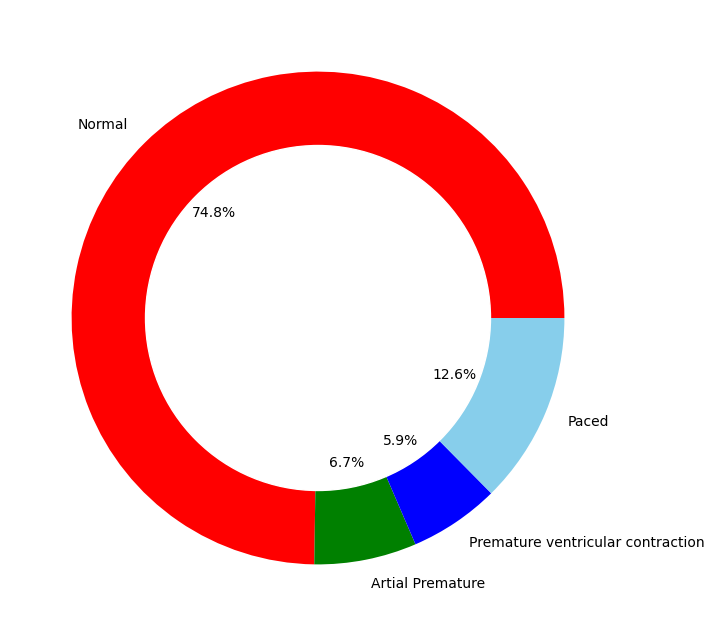

In [18]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [19]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    18118
1      556
2     1448
3     1608
Name: 187, dtype: int64


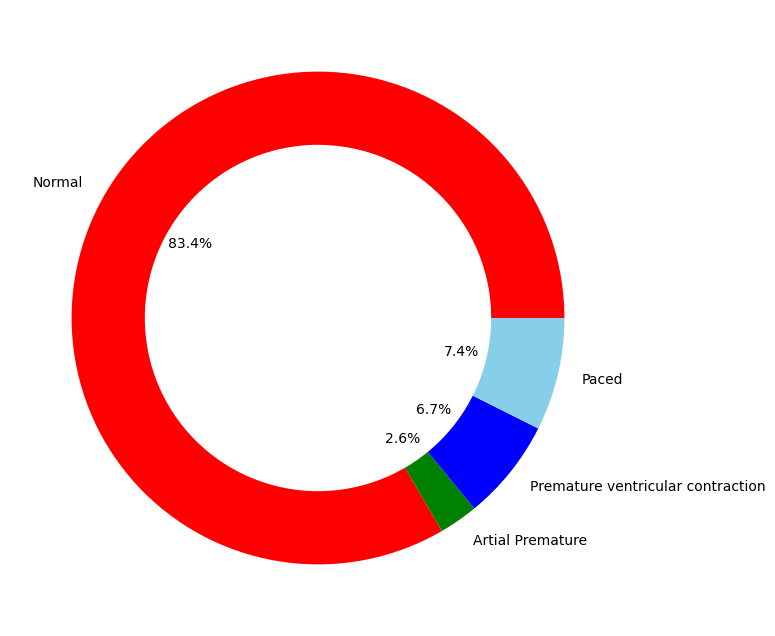

In [20]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Simple ANN

In [ ]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
save_model(model_ann, 'ANN_MITBIH_with_GAN_Data', 'keras')

In [ ]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

## CNN

In [21]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2423/2423 [==============================] - 26s 9ms/step - loss: 0.1209 - accuracy: 0.9656 - val_loss: 0.1105 - val_accuracy: 0.9685
Epoch 2/40
2423/2423 [==============================] - 19s 8ms/step - loss: 0.0709 - accuracy: 0.9802 - val_loss: 0.1234 - val_accuracy: 0.9636
Epoch 3/40
2423/2423 [==============================] - 19s 8ms/step - loss: 0.0571 - accuracy: 0.9832 - val_loss: 0.0680 - val_accuracy: 0.9790
Epoch 4/40
2423/2423 [==============================] - 19s 8ms/step - loss: 0.0482 - accuracy: 0.9855 - val_loss: 0.0609 - val_accuracy: 0.9818
Epoch 5/40
2423/2423 [==============================] - 19s 8ms/step - loss: 0.0424 - accuracy: 0.9874 - val_loss: 0.0792 - val_accuracy: 0.9753
Epoch 6/40
2423/2423 [==============================] - 19s 8ms/step - loss: 0.0375 - accuracy: 0.9886 - val_loss: 0.0384 - val_accuracy: 0.9886
Epoch 7/40
2423/2423 [==============================] - 20s 8ms/step - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.0620 - val_ac

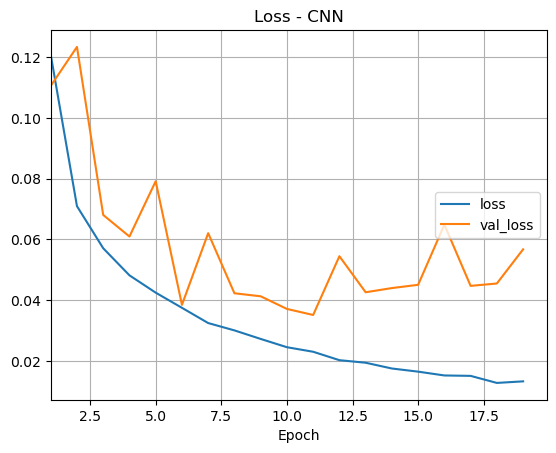

In [22]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

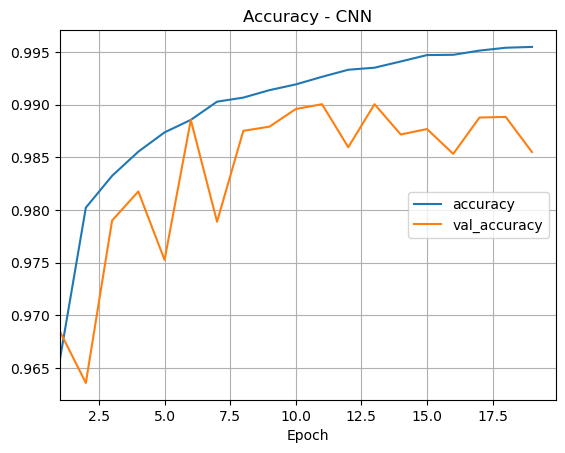

In [23]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [24]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

680/680 [==============================] - 2s 2ms/step
Accuracy of CNN:  0.9897372175433752


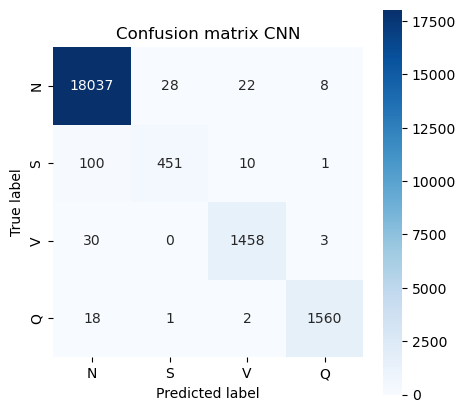

In [25]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [26]:
report = classification_report(y_test, y_pred_cnn, target_names=labels, digits=4)
print(report)

                                   precision    recall  f1-score   support

                           Normal     0.9919    0.9968    0.9943     18095
                 Artial Premature     0.9396    0.8025    0.8656       562
Premature ventricular contraction     0.9772    0.9779    0.9775      1491
                            Paced     0.9924    0.9867    0.9895      1581

                         accuracy                         0.9897     21729
                        macro avg     0.9753    0.9410    0.9568     21729
                     weighted avg     0.9895    0.9897    0.9895     21729



In [27]:
# model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras', report)